<h3>Libraries</h3>

In [4]:
import pandas as pd
import os
import re
import tkinter as tk
from tkinter import simpledialog, scrolledtext, messagebox
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, precision_recall_fscore_support
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, hamming_loss
import itertools
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

<h3>Processing the arff file

In [2]:
#this method will fix and preprocess the arff data
def inspect_and_fix_arff_data(arff_path):
    # Read the content of the ARFF file
    with open(arff_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Variables to track and modify data lines
    data_start = False
    corrected_lines = [] #to store the corrected lines
    issues_count = 0 #to store the number of issues found

    for line in lines:
        if '@data' in line.lower(): # Check if the data section has started
            data_start = True  # Set the flag to start processing data lines
            corrected_lines.append(line)   # Add the line as is
            continue  # Skip to the next line
        
        if data_start:
            # Remove unwanted characters and incorrect formatting
            original_line = line.strip()
            # Assuming the data values are separated by commas without spaces
            elements = original_line.split(',')
            corrected_elements = []
            for el in elements:
                cleaned_el = el.strip('{} ')  # Clean up braces and spaces
                if cleaned_el not in ['0', '1']:
                    cleaned_el = '0'  # Defaulting to '0' if it doesn't match
                    issues_count += 1
                corrected_elements.append(cleaned_el)
            corrected_line = ','.join(corrected_elements) + '\n'
            corrected_lines.append(corrected_line)
        else:
            corrected_lines.append(line)

    # Write the corrected content to a new ARFF file
    corrected_arff_path = arff_path.replace('.arff', '_corrected.arff')
    with open(corrected_arff_path, 'w', encoding='utf-8') as file:
        file.writelines(corrected_lines)

    return f"Fixed {issues_count} issues. Corrected file saved to {corrected_arff_path}"

# Specify the path to your original ARFF file
original_arff_train_path = 'medical-train.arff'

# Call the function to inspect and fix
fix_result = inspect_and_fix_arff_data(original_arff_train_path)
print(fix_result)

Fixed 4828 issues. Corrected file saved to medical-train_corrected.arff


<h3>Converting the arff to a csv file

In [3]:
#Now that this file is cleaned, we'll convert it into a regular csv file
def clean_and_convert_arff_to_csv(arff_path, csv_path):
    # Read the ARFF file content
    with open(arff_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Variables to identify and process the data section
    data_section = False
    data = []
    attributes = []

    # Process each line
    for line in lines:
        if line.strip().lower() == '@data':
            data_section = True  # Identify the start of the data section
            continue
        if not data_section:
            if line.strip().lower().startswith('@attribute'):
                attr_name = line.split()[1].strip()
                attributes.append(attr_name)  # Collect attribute names
        else:
            # Clean and split data entries
            entry = line.strip().replace('{', '').replace('}', '').replace(' ', '')
            parts = entry.split(',')
            if len(parts) == len(attributes):  # Ensure the data line is complete
                # Filter to keep only '0' or '1' values, set default to '0'
                cleaned_parts = [p if p in ['0', '1'] else '0' for p in parts]
                data.append(cleaned_parts)

    # Create a DataFrame from the cleaned data
    df = pd.DataFrame(data, columns=attributes)

    # Save the DataFrame to CSV
    df.to_csv(csv_path, index=False)
    return f"CSV file successfully created at {csv_path}"

# Paths to the ARFF file and the target CSV file
arff_path = 'medical-train_corrected.arff'
csv_path = 'medical-train.csv'

# Convert and clean the ARFF file to CSV
result = clean_and_convert_arff_to_csv(arff_path, csv_path)
print(result)

CSV file successfully created at medical-train.csv


In [6]:
import pandas as pd
import arff

# Function to read ARFF file
def read_arff(file_path):
    with open(file_path, 'r') as file:
        dataset = arff.load(file)
    return dataset

# Path to your ARFF file
file_path = 'medical-train_corrected.arff'

# Read the ARFF file
dataset = read_arff(file_path)

# Convert the ARFF data to a pandas DataFrame
df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])

# Convert byte strings to normal strings (if necessary)
for column in df.select_dtypes([object]):
    df[column] = df[column].str.decode('utf-8')

# Display the DataFrame
print(df)


BadDataFormat: Bad @DATA instance format in line 1499: 0,0,0,0,0,0,0,0,0

In [8]:
def clean_arff_file(file_path, cleaned_file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract attributes to determine the expected number of columns
    attributes = []
    data_started = False
    
    with open(cleaned_file_path, 'w') as cleaned_file:
        for line in lines:
            if '@data' in line.lower():
                data_started = True
                cleaned_file.write(line)
                break
            if '@attribute' in line.lower():
                attributes.append(line)
            cleaned_file.write(line)
        
        expected_num_columns = len(attributes)
        data_lines = lines[lines.index(line) + 1:]
        
        for data_line in data_lines:
            # Skip lines that don't have the expected number of columns
            if len(data_line.split(',')) == expected_num_columns:
                cleaned_file.write(data_line)
            else:
                print(f"Skipped line: {data_line.strip()}")

# Path to your ARFF file
file_path = 'medical-train_corrected.arff'
cleaned_file_path = 'cleaned_medical_train.arff'

# Clean the ARFF file
clean_arff_file(file_path, cleaned_file_path)


dataset = read_arff('cleaned_medical_train.arff')
df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])

for column in df.select_dtypes([object]):
    df[column] = df[column].str.decode('utf-8')

print(df)




Skipped line: 0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Skipped line: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [5]:
df = pd.read_csv('healthcare_dataset.csv')
df

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,eLIZABeTH jaCkSOn,42,Female,O+,Asthma,2020-08-16,Joshua Jarvis,Jones-Thompson,Blue Cross,2650.714952,417,Elective,2020-09-15,Penicillin,Abnormal
55496,KYle pEREz,61,Female,AB-,Obesity,2020-01-23,Taylor Sullivan,Tucker-Moyer,Cigna,31457.797307,316,Elective,2020-02-01,Aspirin,Normal
55497,HEATher WaNG,38,Female,B+,Hypertension,2020-07-13,Joe Jacobs DVM,"and Mahoney Johnson Vasquez,",UnitedHealthcare,27620.764717,347,Urgent,2020-08-10,Ibuprofen,Abnormal
55498,JENniFER JOneS,43,Male,O-,Arthritis,2019-05-25,Kimberly Curry,"Jackson Todd and Castro,",Medicare,32451.092358,321,Elective,2019-05-31,Ibuprofen,Abnormal


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

In [11]:
df.describe()

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000


In [12]:
print(df.columns.unique())

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results'],
      dtype='object')


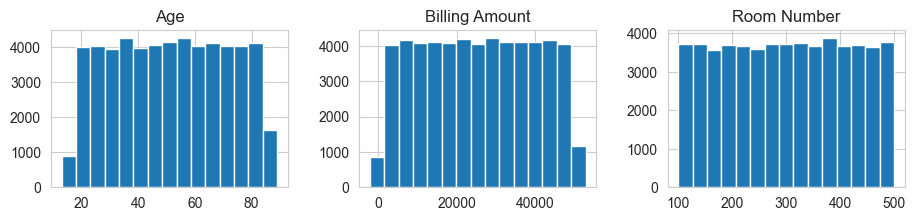

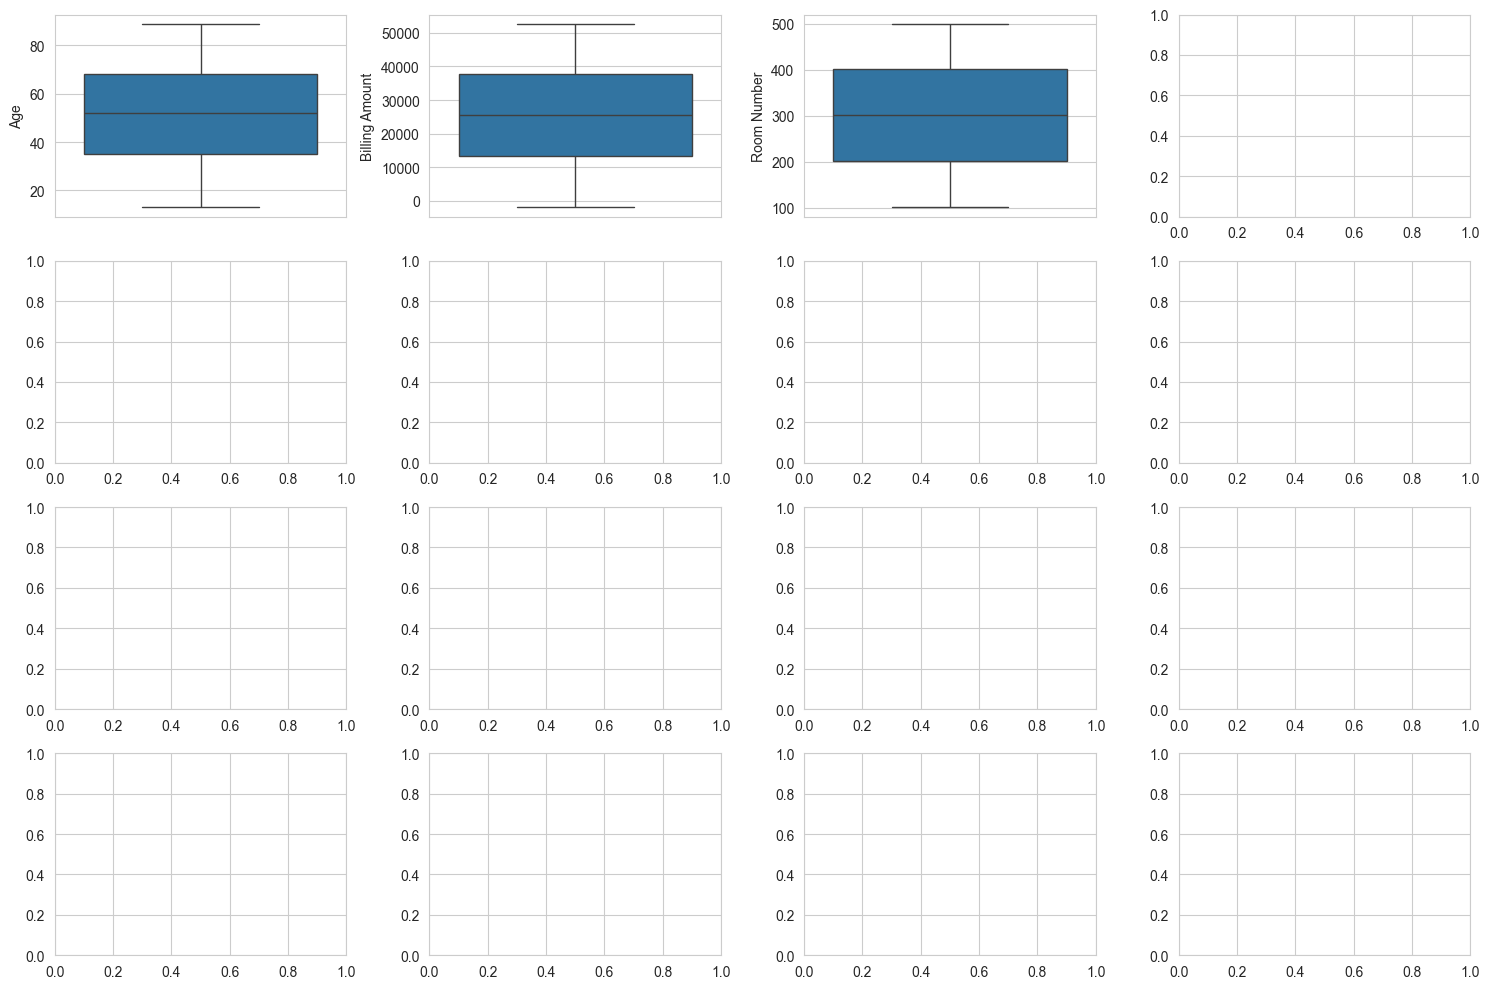

In [16]:
le = LabelEncoder()


# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Histograms for numeric data
df.hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.show()

# Boxplots for numeric data to identify outliers
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
for i, column in enumerate(df.select_dtypes(include=np.number).columns):
    sns.boxplot(y=column, data=df, ax=axes[i//4, i%4])
fig.tight_layout()
plt.show()


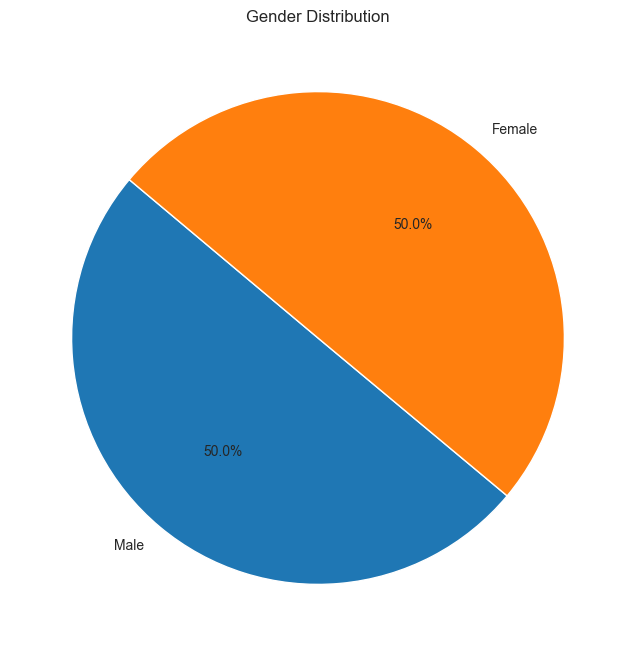

In [17]:
# Pie chart for gender distribution
gender_counts = df['Gender'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.show()

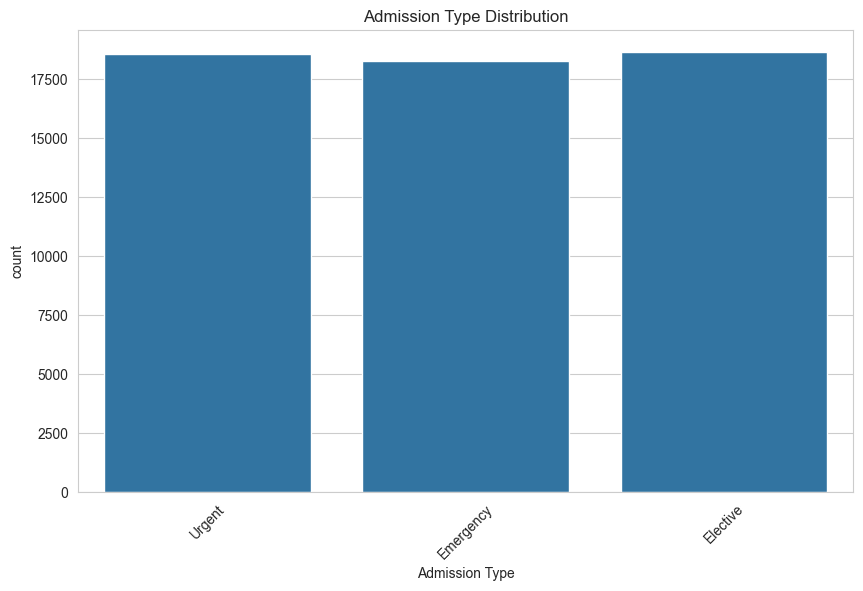

In [18]:
# Count plot for types of admission
plt.figure(figsize=(10, 6))
sns.countplot(x='Admission Type', data=df)
plt.title('Admission Type Distribution')
plt.xticks(rotation=45)
plt.show()

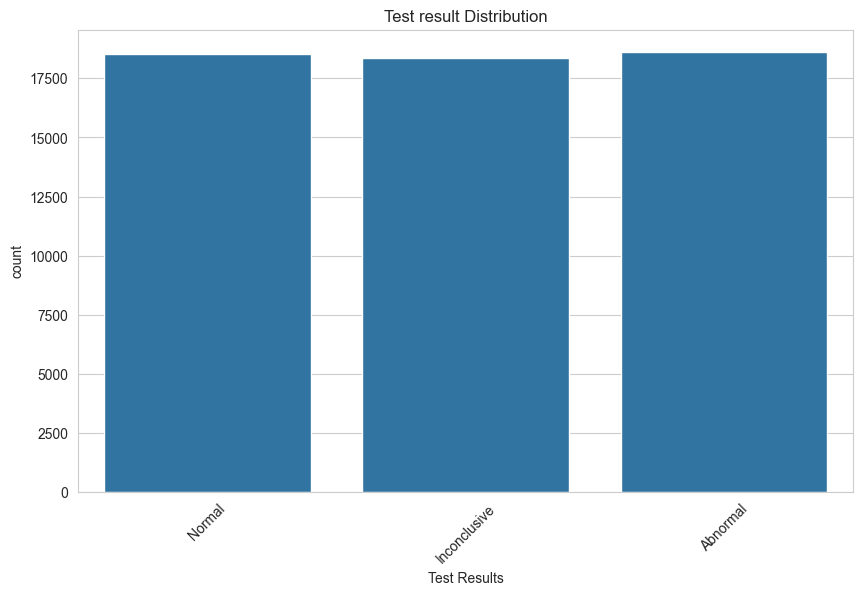

In [20]:
# Count plot for test results(the target variable)
plt.figure(figsize=(10, 6))
sns.countplot(x='Test Results', data=df)
plt.title('Test result Distribution')
plt.xticks(rotation=45)
plt.show()

In [23]:
le = LabelEncoder()
object_cols = df.select_dtypes(include=[object]).columns
print(object_cols)

for col in object_cols:
    df[col] = le.fit_transform(df[col])
    encoded_vals = list(zip(le.classes_, le.transform(le.classes_)))
    print(f"Encoded values for {col}: {encoded_vals}")

Index(['Name', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Admission Type', 'Discharge Date', 'Medication', 'Test Results'],
      dtype='object')
Encoded values for Name: [('AARON DuncAn', 0), ('AARON HicKS', 1), ('AARON bAldWIN Jr.', 2), ('AARON hAWkIns', 3), ('AAROn HaRt', 4), ('AAROn wiLsON', 5), ('AARoN FOSTer', 6), ('AARoN HOPkINs', 7), ('AARoN grEEnE', 8), ('AARon OnEal', 9), ('AARon SmIth', 10), ('AARon goOdwIn', 11), ('AARon poPe', 12), ('AARon smITh', 13), ('AArON BeNtlEy', 14), ('AArON GOoDmAN', 15), ('AArON ROdRIgueZ', 16), ('AArON RiChaRDsON', 17), ('AArON rOmEro', 18), ('AArON sTrICkLanD', 19), ('AArOn AnderSoN', 20), ('AArOn CoOK', 21), ('AArOn DaVIs', 22), ('AArOn STAnLey', 23), ('AArOn huFf', 24), ('AArOn meZa', 25), ('AAroN MArtiN', 26), ('AAroN SwEENEY', 27), ('AAroN bAker', 28), ('AAron ArCHER', 29), ('AAron DicKSoN', 30), ('AAron FisHER', 31), ('AAron LoPez', 32), ('AAron RoWE', 33), (

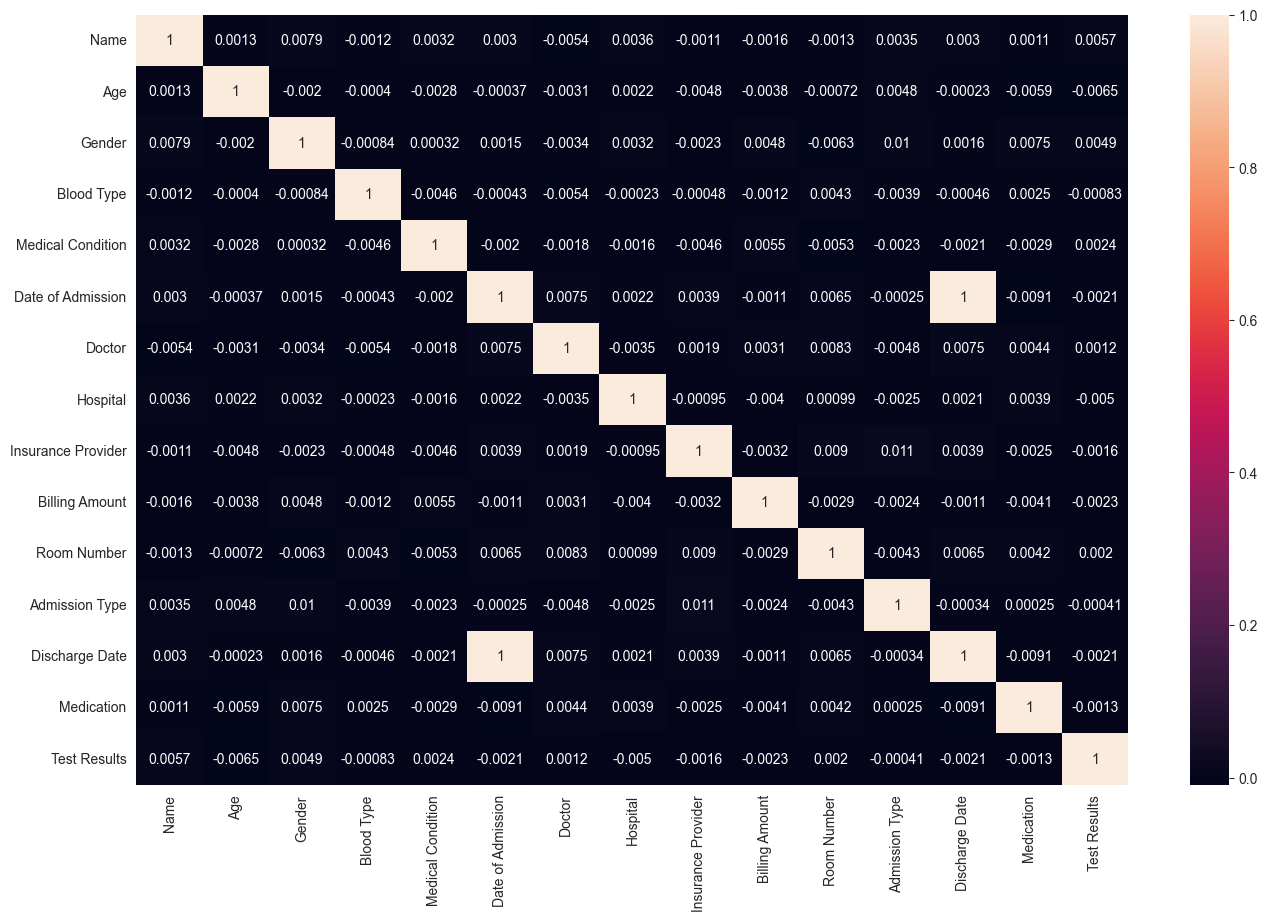

In [25]:
correlation_matrix = df.corr()

plt.figure(figsize = (16, 10))
# Create a heatmap with Seaborn
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [8]:
features_to_drop = ['Name', 'Date of Admission', 'Discharge Date', 'Room Number', 'Insurance Provider']


In [9]:
df = df.drop(columns = features_to_drop, axis = 1)
df

,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Billing Amount,Admission Type,Medication,Test Results
0,30,Male,B-,Cancer,Matthew Smith,Sons and Miller,18856.281306,Urgent,Paracetamol,Normal
1,62,Male,A+,Obesity,Samantha Davies,Kim Inc,33643.327287,Emergency,Ibuprofen,Inconclusive
2,76,Female,A-,Obesity,Tiffany Mitchell,Cook PLC,27955.096079,Emergency,Aspirin,Normal
3,28,Female,O+,Diabetes,Kevin Wells,"Hernandez Rogers and Vang,",37909.782410,Elective,Ibuprofen,Abnormal
4,43,Female,AB+,Cancer,Kathleen Hanna,White-White,14238.317814,Urgent,Penicillin,Abnormal
...,...,...,...,...,...,...,...,...,...,...
55495,42,Female,O+,Asthma,Joshua Jarvis,Jones-Thompson,2650.714952,Elective,Penicillin,Abnormal
55496,61,Female,AB-,Obesity,Taylor Sullivan,Tucker-Moyer,31457.797307,Elective,Aspirin,Normal
55497,38,Female,B+,Hypertension,Joe Jacobs DVM,"and Mahoney Johnson Vasquez,",27620.764717,Urgent,Ibuprofen,Abnormal
55498,43,Male,O-,Arthritis,Kimberly Curry,"Jackson Todd and Castro,",32451.092358,Elective,Ibuprofen,Abnormal


In [10]:
X = df.iloc[:, :-1]
Y = df['Test Results']

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, random_state = 42, shuffle = True)

In [13]:
class MLkNN:
    def __init__(self, k, s=1):
        self.k = k  # Number of nearest neighbors to consider
        self.s = s  # Smoothing parameter for Bayesian adjustment

    def fit(self, X_train, y_train):
        self.n_labels = y_train.shape[1]  # Number of labels in the dataset
        self.neigh = NearestNeighbors(n_neighbors=self.k)  # Initialize the NearestNeighbors model with k neighbors
        self.neigh.fit(X_train)  # Fit the NearestNeighbors model using the training data
        self.y_train = y_train  # Store the training labels

        # Initialize the prior probabilities matrix
        self.prior_prob = np.zeros((self.n_labels, 2))  # Create a zero matrix for prior probabilities, size (n_labels x 2)

        for label in range(self.n_labels):
            # Calculate the number of instances with the current label
            m = np.sum(y_train[:, label])  
            # Compute prior probability for the label being present
            self.prior_prob[label, 1] = (self.s + m) / (self.s * 2 + len(y_train))
            # Compute prior probability for the label being absent
            self.prior_prob[label, 0] = 1 - self.prior_prob[label, 1]

    def predict(self, X_test):
        # Find the k-nearest neighbors for each test instance
        neighbors = self.neigh.kneighbors(X_test, return_distance=False)
        # Initialize the prediction matrix
        y_pred = np.zeros((X_test.shape[0], self.n_labels))  # Create a zero matrix for predictions, size (n_test_samples x n_labels)
        y_prob = np.zeros((X_test.shape[0], self.n_labels))  # Create a zero matrix for probabilities, size (n_test_samples x n_labels)

        for idx, x in enumerate(X_test):
            # Initialize a count matrix for the number of neighbors with each label
            label_counts = np.zeros((self.n_labels, self.k + 1))

            for label in range(self.n_labels):
                # Count the number of neighbors with the current label for the test instance
                neighbor_label_counts = np.zeros(self.k + 1)
                for neighbor in neighbors[idx]:
                    neighbor_label_counts[int(self.y_train[neighbor, label])] += 1

                # Update label counts for the current label
                label_counts[label] = neighbor_label_counts

                # Initialize posterior probability array
                posterior_prob = np.zeros(2)  # Array to store posterior probabilities for the current label (present/absent)

                for j in range(2):
                    posterior_prob[j] = self.prior_prob[label, j]  # Start with the prior probability
                    for count in range(self.k + 1):
                        # Bayesian correction for the posterior probability
                        posterior_prob[j] *= ((self.s + label_counts[label, count]) / 
                                              (self.s * (self.k + 1) + np.sum(label_counts[label, :])))

                # Determine the predicted label by selecting the one with the higher posterior probability
                y_pred[idx, label] = np.argmax(posterior_prob)

                # Calculate the probability ~rt(l) of label l being present in t
                y_prob[idx, label] = (self.prior_prob[label, 1] * posterior_prob[1]) / \
                                     (self.prior_prob[label, 0] * posterior_prob[0] + self.prior_prob[label, 1] * posterior_prob[1])

        return y_pred, y_prob  # Return the prediction matrix and probability matrix

In [14]:
model = MLkNN(k = 3, s = 1)
model.fit(x_train, y_train)

ml_knn_pred, ml_knn_prob = model.predict(y_test)



IndexError: tuple index out of range